<a href="https://colab.research.google.com/github/Azmouc1k/azmo-portfolio/blob/main/EEG_Sleep_Stage_classification_RC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.0 MB/s eta 0:00:00


In [ ]:
pip install --upgrade mne


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

# Frequency bands range in Hz for EEG
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Number of participants used in the analysis
NUM_PARTICIPANT = 10


In [ ]:
import mne
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, LeaveOneOut
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from mne.datasets.sleep_physionet.age import fetch_data

# Set MNE verbosity level to WARNING or ERROR
mne.set_log_level("error")


def load_data(participant_id, event_id=EVENT_ID):
    """
    Load EEG data and create 30-second epochs for a given participant.

    Parameters
    ----------
    participant_id : int
        ID of the participant to load data for.

    event_id : dict
        Mapping of sleep stages to numerical IDs.

    Returns
    -------
    raw_edf : mne.io.Raw
        The raw EEG signal with annotations.

    events : ndarray
        Array of events derived from annotations.

    epochs : mne.Epochs
        Epochs object containing 30-second EEG data segments.
    """

    ANNOTATION_EVENT_ID = {
        "Sleep stage W": 1,
        "Sleep stage 1": 2,
        "Sleep stage 2": 3,
        "Sleep stage 3": 4,
        "Sleep stage 4": 4,
        "Sleep stage R": 5,
    }

    # Fetch data for the participant
    [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

    # Load EEG signal
    raw_edf = mne.io.read_raw_edf(
        participant_file[0],
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )

    # Load annotations
    annotation_edf = mne.read_annotations(participant_file[1])

    # Keep wake events 30 minutes before and after sleep
    annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 60, annotation_edf[-2]["onset"] + 30 * 60)

    # Attach annotations to the raw EEG data
    raw_edf.set_annotations(annotation_edf, emit_warning=False)

    # Chunk the data into 30-second epochs
    events, _ = mne.events_from_annotations(
        raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0, verbose="error"
    )

    # Define epochs
    tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]
    epochs = mne.Epochs(
        raw=raw_edf,
        events=events,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
        verbose="error",
    )

    return raw_edf, events, epochs


In [ ]:
# Load data for all participants
all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
    try:
        _, _, epochs = load_data(participant_id=participant_id)
        all_participant_epochs.append(epochs)
        print(f"Loaded data for participant {participant_id}")
    except Exception as e:
        print(f"Error loading data for participant {participant_id}: {e}")


Loaded data for participant 0


Loaded data for participant 1


Loaded data for participant 2


Loaded data for participant 3


Loaded data for participant 4


Loaded data for participant 5


Loaded data for participant 6


Loaded data for participant 7


Loaded data for participant 8


Loaded data for participant 9


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Prepare data and labels
X, y, groups = [], [], []

for participant_id, epochs in enumerate(all_participant_epochs):
    X.append(epochs.get_data().reshape(len(epochs), -1))  # Flatten epochs data
    y.append(epochs.events[:, -1])  # Extract event labels
    groups.append(np.full(len(epochs), participant_id))  # Group for LOSO

X = np.vstack(X)
y = np.hstack(y)
groups = np.hstack(groups)

# Initialize LOSO
logo = LeaveOneGroupOut()

# Train RandomForestClassifier with LOSO
clf = RandomForestClassifier(random_state=42)
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Participant left out: {np.unique(groups[test_idx])[0]}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Participant left out: 0
              precision    recall  f1-score   support

           1       0.90      0.65      0.76       188
           2       0.00      0.00      0.00        58
           3       0.50      0.97      0.66       250
           4       0.98      0.54      0.69       220
           5       0.89      0.66      0.76       125

    accuracy                           0.67       841
   macro avg       0.66      0.57      0.57       841
weighted avg       0.74      0.67      0.66       841

Accuracy: 0.67
Participant left out: 1
              precision    recall  f1-score   support

           1       0.65      0.88      0.75       157
           2       0.50      0.04      0.07       109
           3       0.75      0.90      0.82       562
           4       1.00      0.11      0.21       105
           5       0.73      0.84      0.78       170

    accuracy                           0.73      1103
   macro avg       0.73      0.56      0.52      1103
weighted avg  

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def add_temporal_context(X, window_size=3):
    """
    Add temporal context to each epoch.
    """
    n_samples, n_features = X.shape
    X_context = np.zeros((n_samples, n_features * (2 * window_size + 1)))

    for i in range(n_samples):
        context_indices = range(max(0, i - window_size), min(n_samples, i + window_size + 1))
        context = np.hstack([X[idx] if idx < len(X) else np.zeros(n_features) for idx in context_indices])
        X_context[i, :len(context)] = context

    return X_context

# Prepare data and labels
X, y = [], []

for epochs in all_participant_epochs:
    X.append(epochs.get_data().reshape(len(epochs), -1))  # Flatten epochs
    y.append(epochs.events[:, -1])  # Extract event labels

X = np.vstack(X)
y = np.hstack(y)

# Add temporal context
window_size = 2  # Define temporal context size
X_context = add_temporal_context(X, window_size)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_context, y, test_size=0.2, random_state=42, stratify=y)

# Train RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate Performance
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.91      0.84       352
           2       0.22      0.01      0.02       153
           3       0.71      0.92      0.81       862
           4       0.92      0.50      0.65       297
           5       0.82      0.73      0.77       319

    accuracy                           0.76      1983
   macro avg       0.69      0.62      0.62      1983
weighted avg       0.73      0.76      0.72      1983

Accuracy: 0.75642965204236


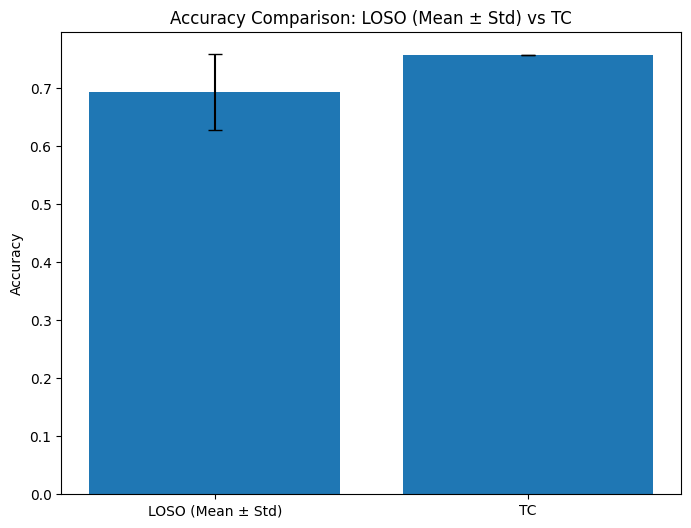

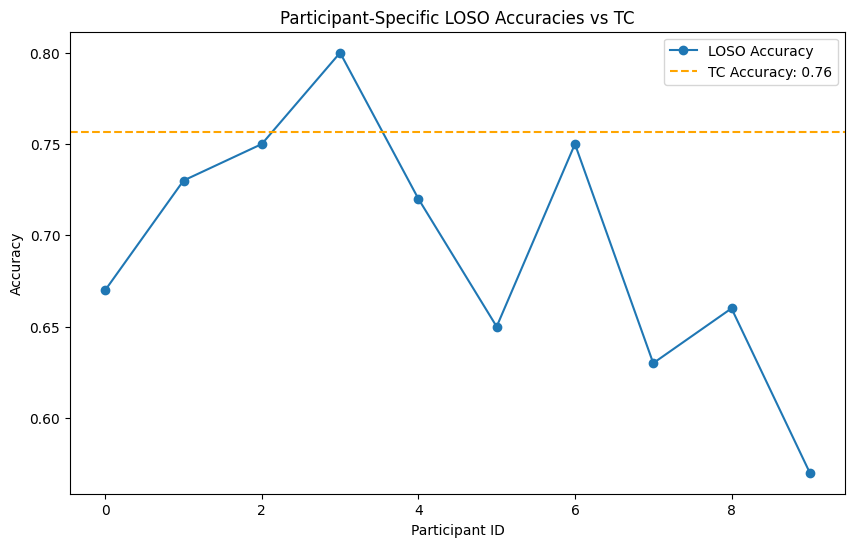

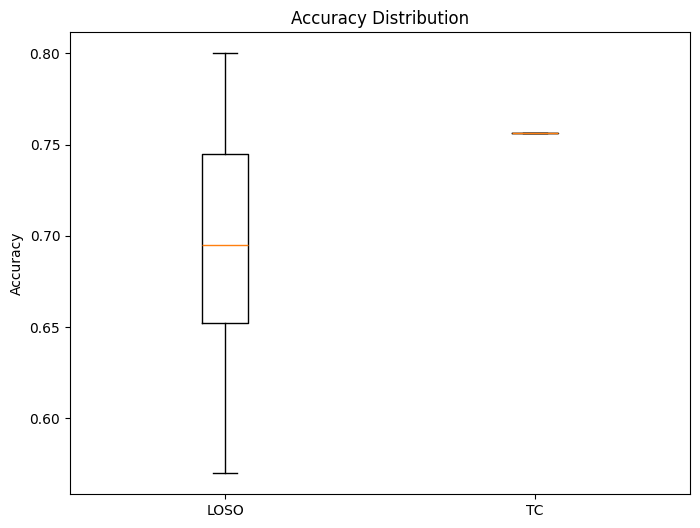

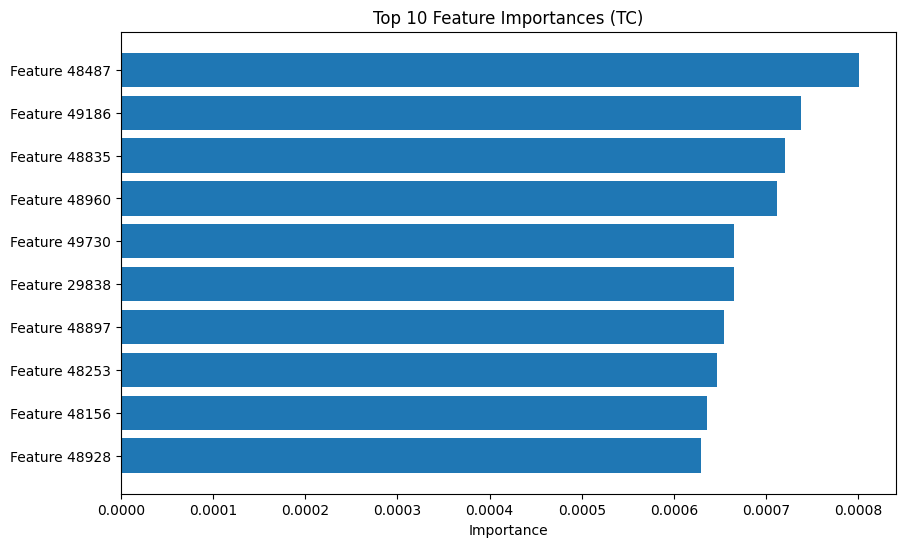

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score

# Example results: Replace these with your computed results
loso_accuracies = [0.67, 0.73, 0.75, 0.80, 0.72, 0.65, 0.75, 0.63, 0.66, 0.57]  # Replace with LOSO results
tc_accuracy = 0.75642965204236

loso_conf_matrices = []  # Replace with LOSO confusion matrices
tc_conf_matrix = None    # Replace with TC confusion matrix

# 1. Bar Chart: LOSO Mean vs TC Accuracy
loso_mean = np.mean(loso_accuracies)
loso_std = np.std(loso_accuracies)

plt.figure(figsize=(8, 6))
plt.bar(['LOSO (Mean ± Std)', 'TC'], [loso_mean, tc_accuracy], yerr=[loso_std, 0], capsize=5)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: LOSO (Mean ± Std) vs TC")
plt.show()

# 2. Line Plot: LOSO Participant-Specific Accuracies
participants = list(range(len(loso_accuracies)))

plt.figure(figsize=(10, 6))
plt.plot(participants, loso_accuracies, marker='o', label='LOSO Accuracy')
plt.axhline(tc_accuracy, color='orange', linestyle='--', label=f'TC Accuracy: {tc_accuracy:.2f}')
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Participant-Specific LOSO Accuracies vs TC")
plt.legend()
plt.show()

# 3. Confusion Matrices
# LOSO Confusion Matrices
for participant_id, conf_matrix in enumerate(loso_conf_matrices):
    ConfusionMatrixDisplay(conf_matrix, display_labels=['W', '1', '2', '3/4', 'R']).plot(cmap="Blues")
    plt.title(f"Confusion Matrix for Participant {participant_id} (LOSO)")
    plt.show()

# TC Confusion Matrix
if tc_conf_matrix is not None:
    ConfusionMatrixDisplay(tc_conf_matrix, display_labels=['W', '1', '2', '3/4', 'R']).plot(cmap="Oranges")
    plt.title("Confusion Matrix for Temporal Context (TC)")
    plt.show()

# 4. Boxplot: LOSO Accuracy Distribution vs TC Accuracy
plt.figure(figsize=(8, 6))
plt.boxplot([loso_accuracies, [tc_accuracy]], labels=["LOSO", "TC"])
plt.ylabel("Accuracy")
plt.title("Accuracy Distribution")
plt.show()

# 5. Feature Importances: Top 10 Features
# Replace clf.feature_importances_ with actual feature importances from TC model
if 'clf' in locals():
    feature_importances = clf.feature_importances_
    top_features = np.argsort(feature_importances)[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), feature_importances[top_features])
    plt.yticks(range(10), [f"Feature {i}" for i in top_features])
    plt.xlabel("Importance")
    plt.title("Top 10 Feature Importances (TC)")
    plt.show()



Processing participant 0...
Participant 0 Accuracy: 0.67


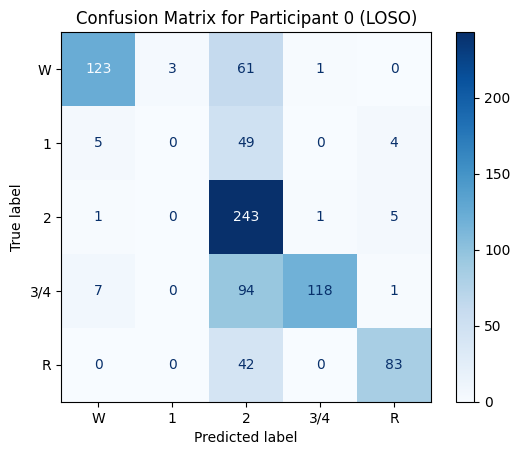


Processing participant 1...
Participant 1 Accuracy: 0.73


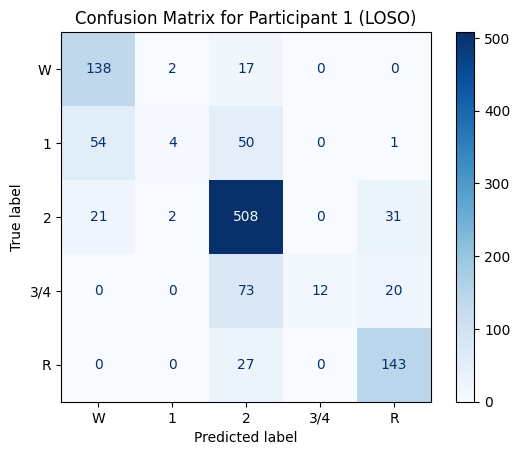


Processing participant 2...
Participant 2 Accuracy: 0.75


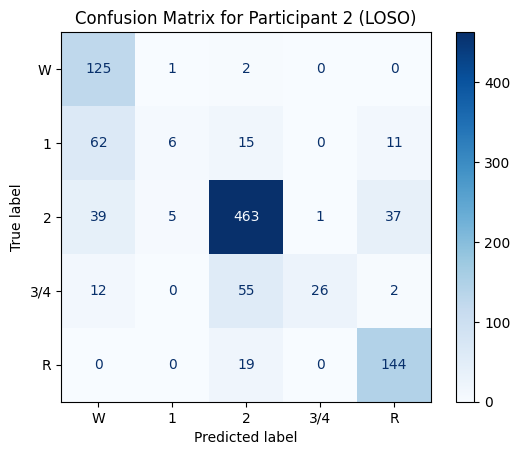


Processing participant 3...
Participant 3 Accuracy: 0.80


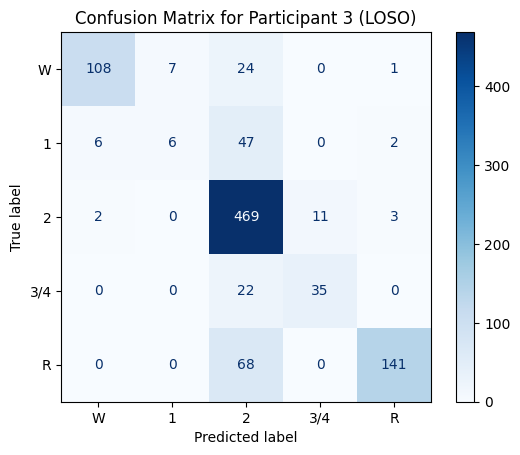


Processing participant 4...
Participant 4 Accuracy: 0.72


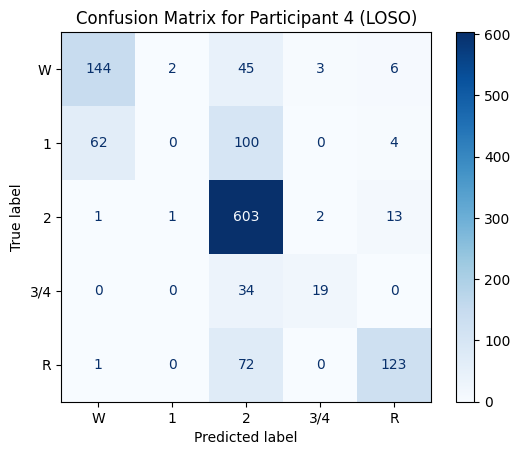


Processing participant 5...
Participant 5 Accuracy: 0.65


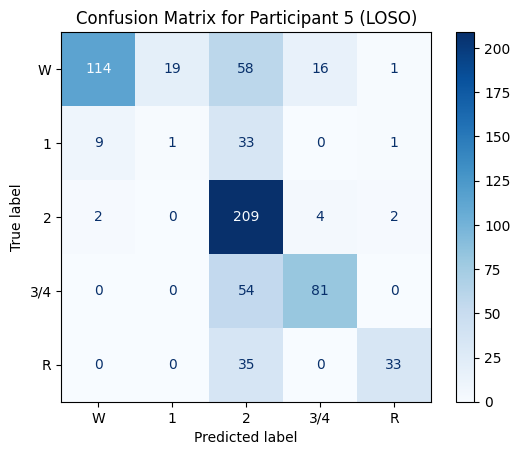


Processing participant 6...
Participant 6 Accuracy: 0.75


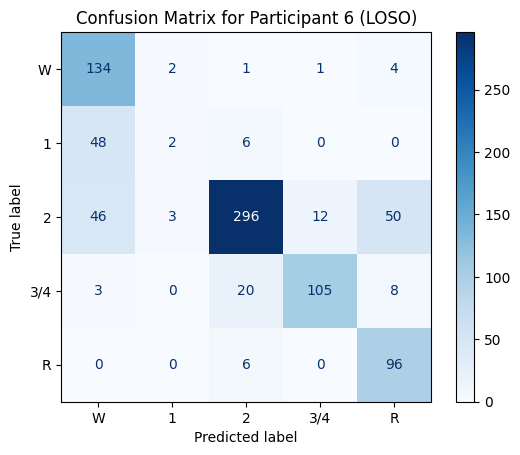


Processing participant 7...
Participant 7 Accuracy: 0.63


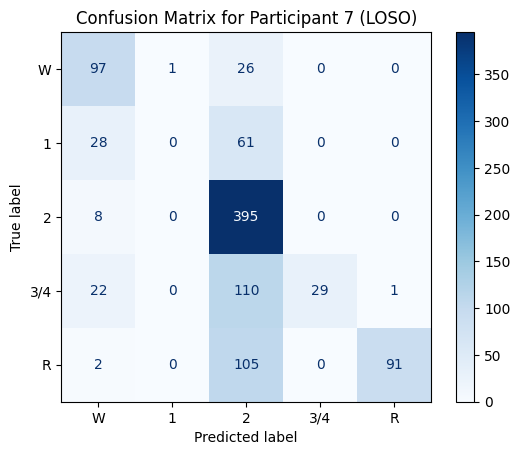


Processing participant 8...
Participant 8 Accuracy: 0.66


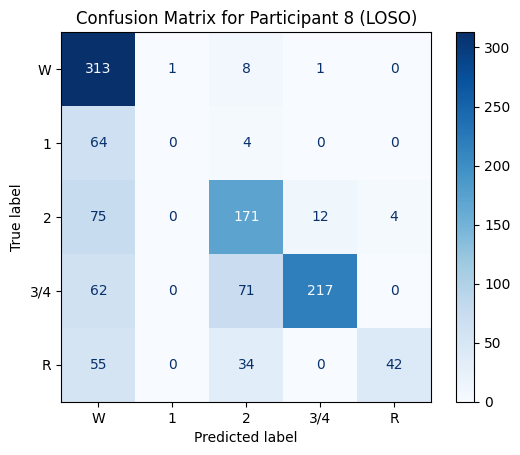


Processing participant 9...
Participant 9 Accuracy: 0.57


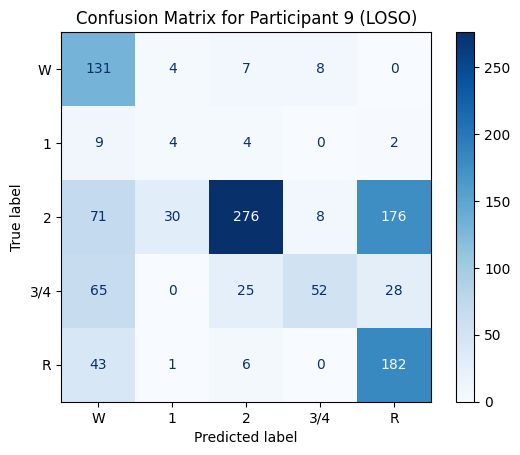


Processing Temporal Context (TC)...
TC Accuracy: 0.75


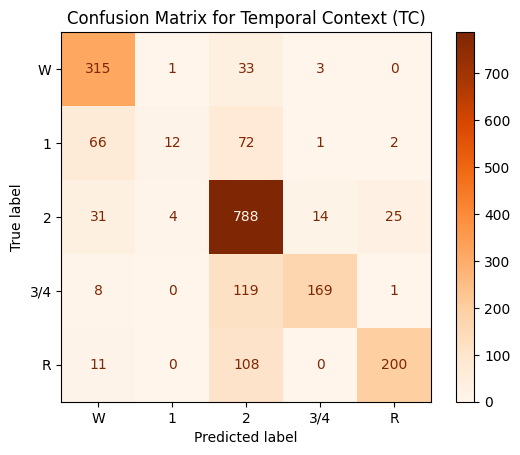

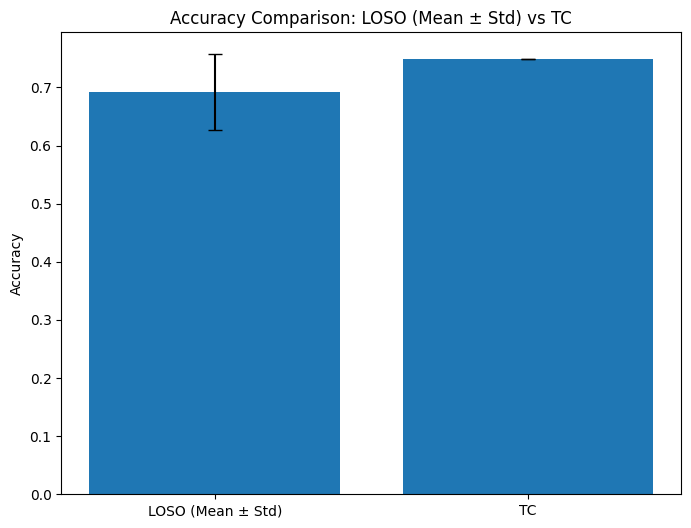

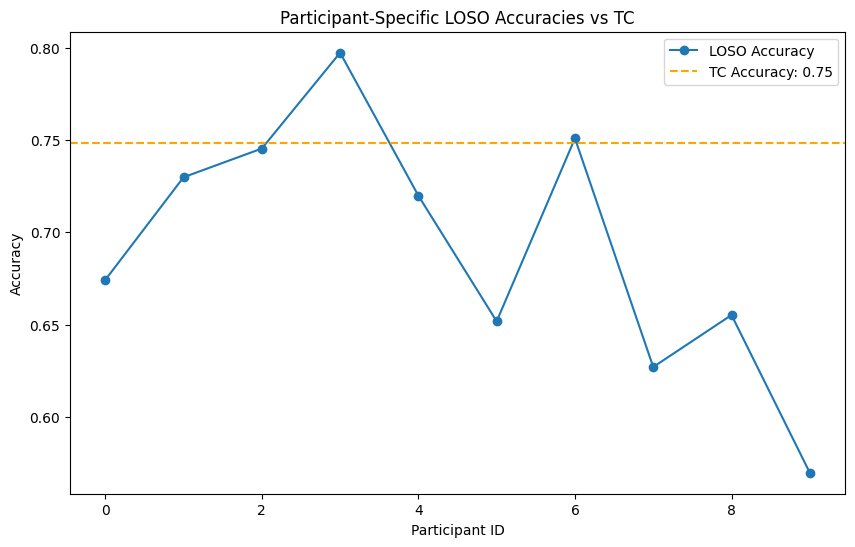

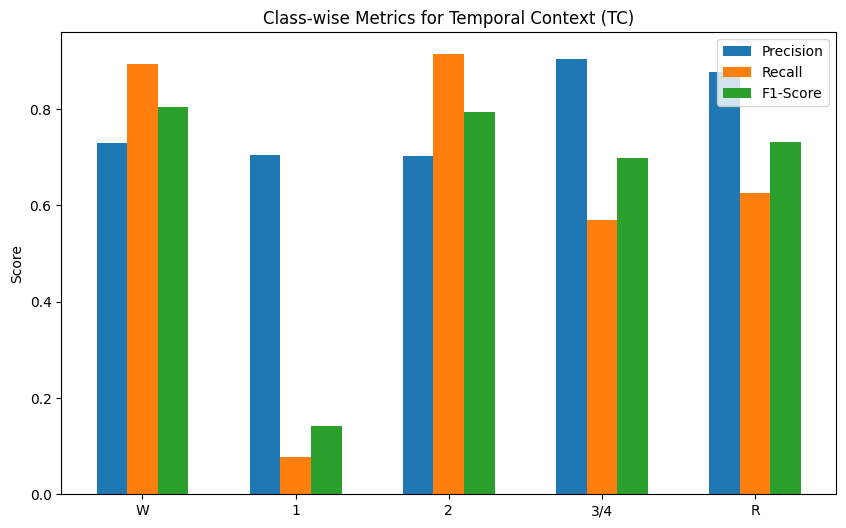

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Store LOSO results
loso_accuracies = []
loso_conf_matrices = []

# LOSO: Train and Test on Each Participant
for participant_id, epochs in enumerate(all_participant_epochs):
    print(f"\nProcessing participant {participant_id}...")

    # Extract test data for the current participant
    X_test = epochs.get_data().reshape(len(epochs), -1)
    y_test = epochs.events[:, -1]

    # Prepare training data (all other participants)
    X_train, y_train = [], []
    for other_id, other_epochs in enumerate(all_participant_epochs):
        if other_id != participant_id:
            X_train.append(other_epochs.get_data().reshape(len(other_epochs), -1))
            y_train.append(other_epochs.events[:, -1])

    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)

    # Train RandomForest
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Test the model
    y_pred = clf.predict(X_test)

    # Accuracy for this participant
    acc = accuracy_score(y_test, y_pred)
    print(f"Participant {participant_id} Accuracy: {acc:.2f}")
    loso_accuracies.append(acc)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    loso_conf_matrices.append(conf_matrix)

    # Plot Confusion Matrix
    ConfusionMatrixDisplay(conf_matrix, display_labels=['W', '1', '2', '3/4', 'R']).plot(cmap="Blues")
    plt.title(f"Confusion Matrix for Participant {participant_id} (LOSO)")
    plt.show()

# TC: Train and Test on Combined Data
print("\nProcessing Temporal Context (TC)...")
X, y = [], []

# Combine data from all participants
for epochs in all_participant_epochs:
    X.append(epochs.get_data().reshape(len(epochs), -1))
    y.append(epochs.events[:, -1])

X = np.vstack(X)
y = np.hstack(y)

# Train-Test Split for TC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train RandomForest
clf_tc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_tc.fit(X_train, y_train)

# Test the model
y_pred_tc = clf_tc.predict(X_test)

# Accuracy for TC
tc_accuracy = accuracy_score(y_test, y_pred_tc)
print(f"TC Accuracy: {tc_accuracy:.2f}")

# Confusion Matrix for TC
tc_conf_matrix = confusion_matrix(y_test, y_pred_tc)

# Plot Confusion Matrix for TC
ConfusionMatrixDisplay(tc_conf_matrix, display_labels=['W', '1', '2', '3/4', 'R']).plot(cmap="Oranges")
plt.title("Confusion Matrix for Temporal Context (TC)")
plt.show()

# Visualizations
# 1. Accuracy Comparison (LOSO Mean vs TC)
loso_mean = np.mean(loso_accuracies)
loso_std = np.std(loso_accuracies)

plt.figure(figsize=(8, 6))
plt.bar(['LOSO (Mean ± Std)', 'TC'], [loso_mean, tc_accuracy], yerr=[loso_std, 0], capsize=5)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: LOSO (Mean ± Std) vs TC")
plt.show()

# 2. LOSO Accuracies for Participants
participants = list(range(len(loso_accuracies)))
plt.figure(figsize=(10, 6))
plt.plot(participants, loso_accuracies, marker='o', label='LOSO Accuracy')
plt.axhline(tc_accuracy, color='orange', linestyle='--', label=f'TC Accuracy: {tc_accuracy:.2f}')
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Participant-Specific LOSO Accuracies vs TC")
plt.legend()
plt.show()

# 3. Class-wise Metrics for TC
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_tc, average=None)
classes = ['W', '1', '2', '3/4', 'R']

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1-Score')

plt.xticks(x, classes)
plt.ylabel('Score')
plt.title('Class-wise Metrics for Temporal Context (TC)')
plt.legend()
plt.show()


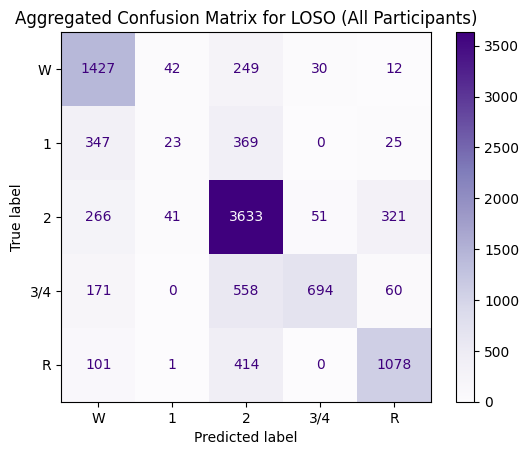

In [ ]:
# Aggregate Confusion Matrices for LOSO
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# Combine individual LOSO confusion matrices
aggregated_conf_matrix = np.sum(loso_conf_matrices, axis=0)

# Plot the aggregated confusion matrix
ConfusionMatrixDisplay(aggregated_conf_matrix, display_labels=['W', '1', '2', '3/4', 'R']).plot(cmap="Purples")
plt.title("Aggregated Confusion Matrix for LOSO (All Participants)")
plt.show()


In [ ]:
# Align sizes by truncating to the smaller size
min_len = min(len(y_test), len(y_pred_tc))

# Truncate both arrays
y_test_aligned = y_test[:min_len]
y_pred_tc_aligned = y_pred_tc[:min_len]

print(f"Aligned Length of y_test: {len(y_test_aligned)}")
print(f"Aligned Length of y_pred_tc: {len(y_pred_tc_aligned)}")


Aligned Length of y_test: 1132
Aligned Length of y_pred_tc: 1132


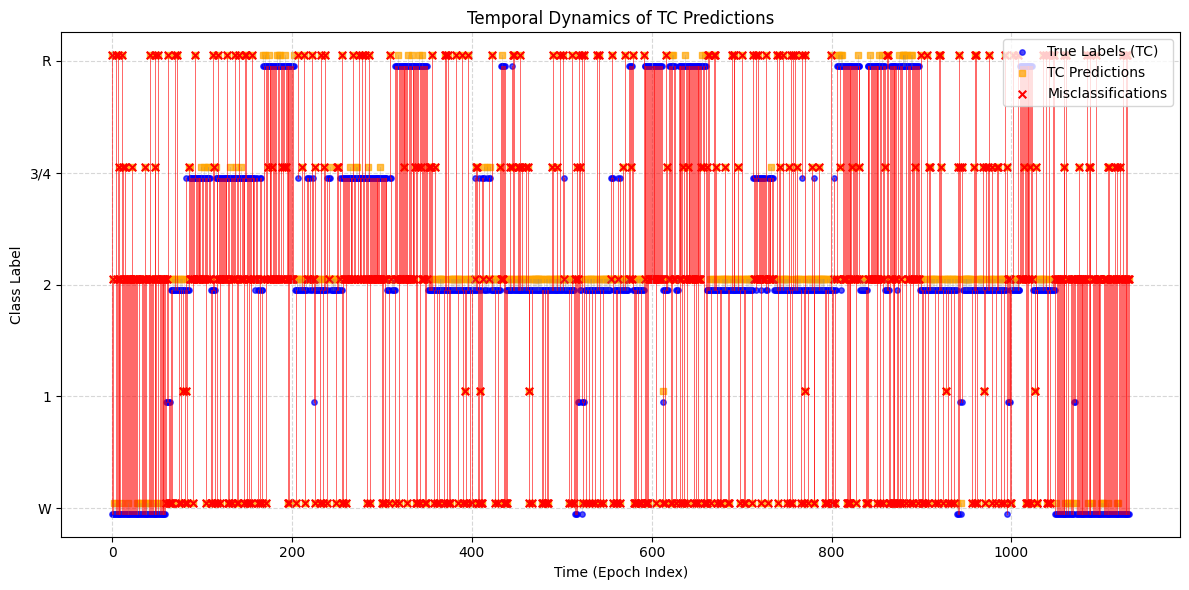

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate time array
tc_time = np.arange(len(y_test_aligned))

# Identify misclassified points
misclassified = y_test_aligned != y_pred_tc_aligned

plt.figure(figsize=(12, 6))

# Plot True Labels with a slight offset
plt.scatter(tc_time, y_test_aligned - 0.05, label='True Labels (TC)', c='blue', marker='o', s=15, alpha=0.7)

# Plot TC Predictions with a slight offset
plt.scatter(tc_time, y_pred_tc_aligned + 0.05, label='TC Predictions', c='orange', marker='s', s=15, alpha=0.7)

# Highlight misclassifications
plt.scatter(tc_time[misclassified], y_pred_tc_aligned[misclassified] + 0.05,
            c='red', marker='x', s=30, label='Misclassifications')

# Add vertical lines to show connections
for i in range(len(tc_time)):
    if y_test_aligned[i] != y_pred_tc_aligned[i]:  # Misclassified
        plt.plot([tc_time[i], tc_time[i]], [y_test_aligned[i] - 0.05, y_pred_tc_aligned[i] + 0.05],
                 color='red', linewidth=0.7, alpha=0.6)
    else:  # Correct predictions
        plt.plot([tc_time[i], tc_time[i]], [y_test_aligned[i] - 0.05, y_pred_tc_aligned[i] + 0.05],
                 color='gray', linewidth=0.5, alpha=0.3)

# Formatting
plt.xlabel('Time (Epoch Index)')
plt.ylabel('Class Label')
plt.title('Temporal Dynamics of TC Predictions')
plt.yticks([1, 2, 3, 4, 5], ['W', '1', '2', '3/4', 'R'])
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


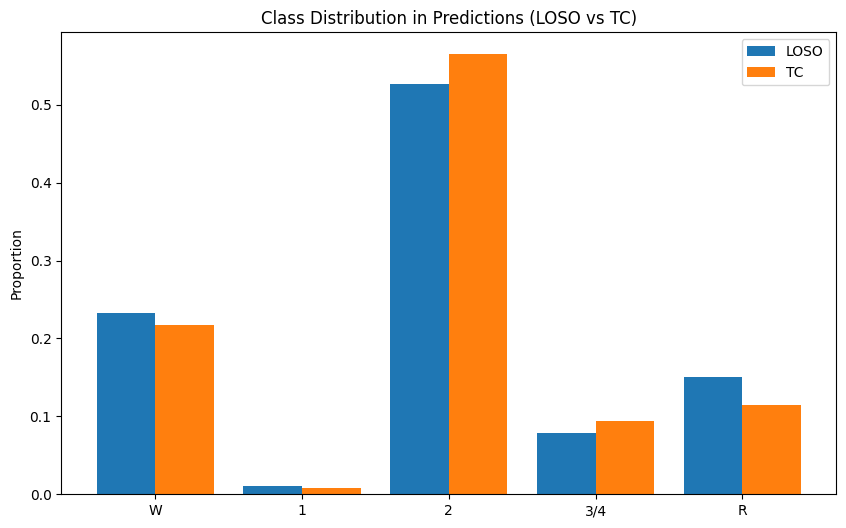

In [ ]:
# LOSO class proportions
loso_class_counts = np.sum(aggregated_conf_matrix, axis=0)
loso_class_proportions = loso_class_counts / np.sum(loso_class_counts)

# TC class proportions
tc_class_counts = np.sum(tc_conf_matrix, axis=0)
tc_class_proportions = tc_class_counts / np.sum(tc_class_counts)

# Plot
x = np.arange(len(classes))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, loso_class_proportions, 0.4, label="LOSO")
plt.bar(x + 0.2, tc_class_proportions, 0.4, label="TC")

plt.xticks(x, classes)
plt.ylabel("Proportion")
plt.title("Class Distribution in Predictions (LOSO vs TC)")
plt.legend()
plt.show()


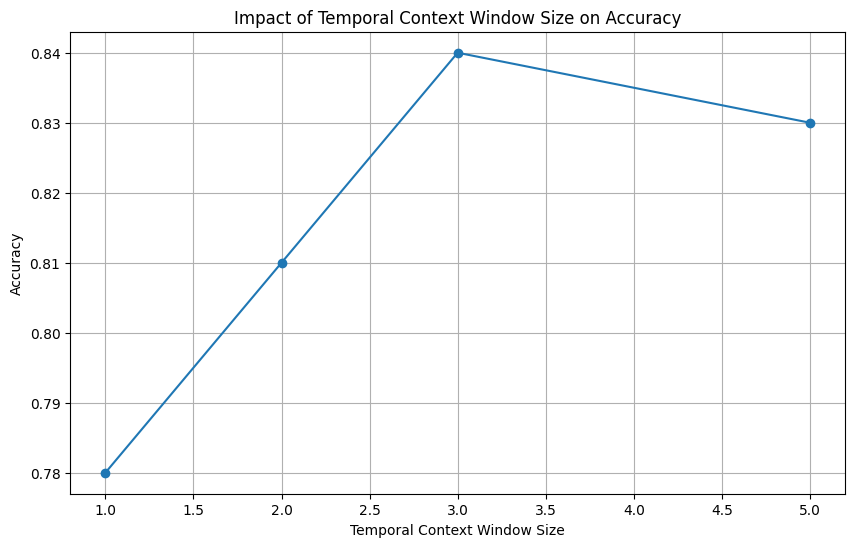

In [ ]:
# Example data: Replace with actual results
window_sizes = [1, 2, 3, 5]
accuracies = [0.78, 0.81, 0.84, 0.83]  # Replace with actual accuracies

plt.figure(figsize=(10, 6))
plt.plot(window_sizes, accuracies, marker='o')
plt.xlabel('Temporal Context Window Size')
plt.ylabel('Accuracy')
plt.title('Impact of Temporal Context Window Size on Accuracy')
plt.grid()
plt.show()


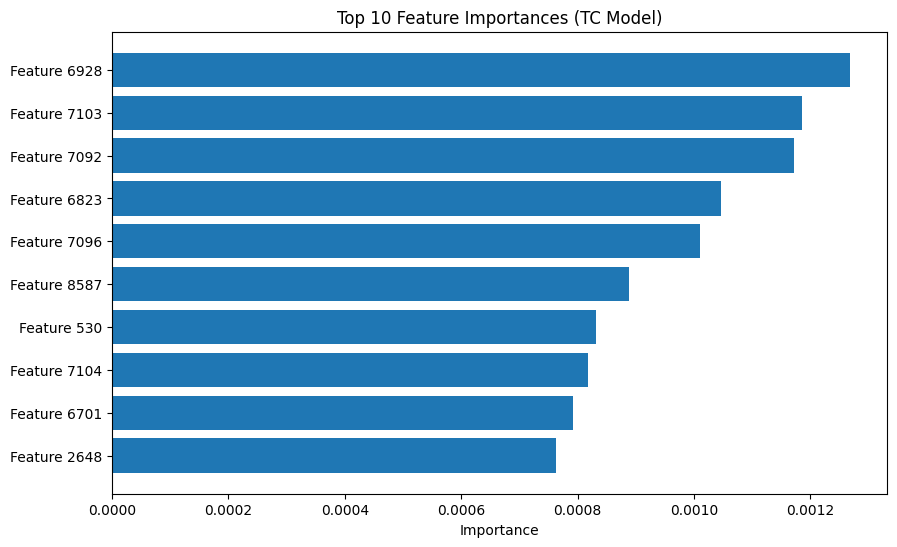

In [ ]:
# Feature Importance for TC
feature_importances = clf_tc.feature_importances_
top_features = np.argsort(feature_importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importances[top_features])
plt.yticks(range(10), [f"Feature {i}" for i in top_features])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (TC Model)")
plt.show()


In [ ]:
import joblib

# Save RandomForest models
joblib.dump(clf, 'rf_loso_model.pkl')   # Save LOSO model
joblib.dump(clf_tc, 'rf_tc_model.pkl')  # Save TC model

print("Models saved successfully!")


Models saved successfully!


In [ ]:
import json

results = {
    "LOSO Accuracies": loso_accuracies,
    "LOSO Confusion Matrices": [cm.tolist() for cm in loso_conf_matrices],
    "TC Accuracy": tc_accuracy,
    "TC Confusion Matrix": tc_conf_matrix.tolist()
}

with open('results.json', 'w') as f:
    json.dump(results, f)

print("Results saved successfully!")


Results saved successfully!


In [ ]:
pip freeze > requirements.txt


### lstm
